## Prediction model for workout types

### imports

In [7]:
import shutil
import os, os.path
import splitfolders 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix


### data exploration

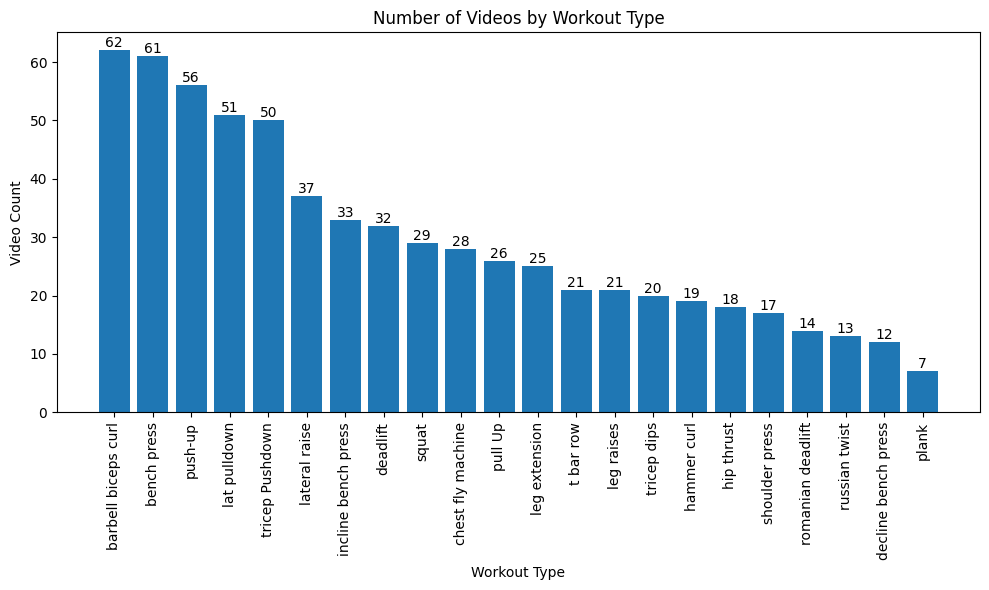

In [14]:
# get an idea of how many videos in each folder (type) 
data_dir = '/Users/mirimichaeli/projects/video_classisifcation/workoutfitness-video'

video_count = {}
for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir, category)
    video_count[os.path.basename(category_dir)] = len([entry for entry in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, entry))])

video_count_df = pd.DataFrame({'workout_type' : video_count.keys(),
                               'video_count' : video_count.values()})
video_count_df.sort_values(by='video_count', ascending=False, inplace=True)

# Plotting
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(video_count_df['workout_type'], video_count_df['video_count'])
plt.xlabel('Workout Type')
plt.ylabel('Video Count')
plt.title('Number of Videos by Workout Type')
plt.xticks(rotation=90)
# Adding labels to each bar
for i, count in enumerate(video_count_df['video_count']):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()


In [ ]:
# get an idea of the duration of videos per type:
video_lengths_list = []
for category in os.listdir(data_dir):
    category_dir = os.path.join(data_dir, category)
    for video_file in os.listdir(category_dir):
        video_path = os.path.join(category_dir, video_file)
        # Open the video file
        video = cv2.VideoCapture(video_path)
        # Get the total number of frames in the video
        num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

        # Get the frame rate of the video
        frame_rate = video.get(cv2.CAP_PROP_FPS)

        # Calculate the duration in milliseconds
        duration_ms = int((num_frames / frame_rate) * 1000)

        # Release the video capture object
        video.release()

        # document the results
        video_dict = {
        'workout_type': category,
        'video_file': video_file,
        'duration_ms': duration_ms,
        'num_of_frames': num_frames
        }
        video_lengths_list.append(video_dict)
        
video_lengths = pd.DataFrame(video_lengths_list)
# video_lengths

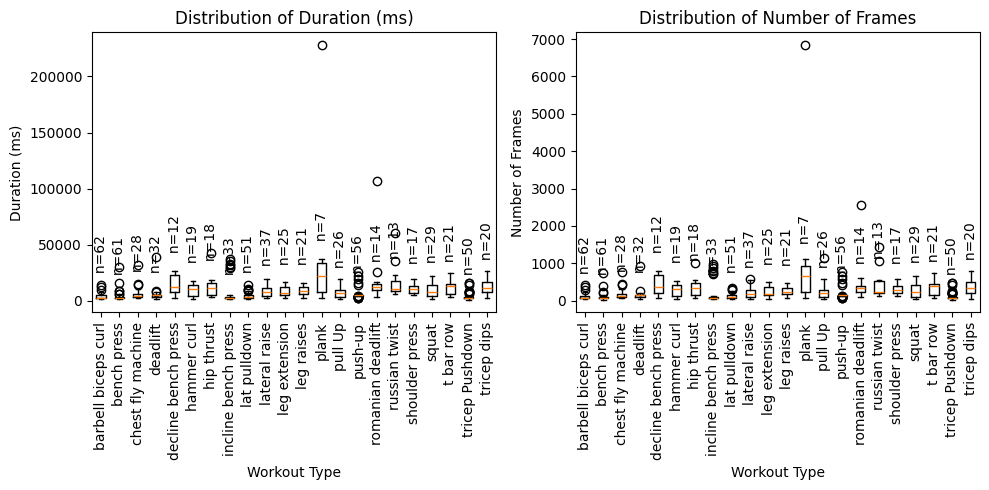

In [59]:
# Group the DataFrame by workout_type
grouped_df = video_lengths.groupby('workout_type')

# Create an empty list to store the duration_ms values for each workout_type
data_duration = []

# Create an empty list to store the num_of_frames values for each workout_type
data_frames = []

# Create an empty list to store the count of instances in each group
counts = []

# Iterate over the groups and extract duration_ms and num_of_frames values, and count the instances
for workout_type, group_df in grouped_df:
    data_duration.append(group_df['duration_ms'].values)
    data_frames.append(group_df['num_of_frames'].values)
    counts.append(len(group_df))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the duration_ms boxplot
bp_duration = axes[0].boxplot(data_duration, showfliers=True)  # Include outliers
axes[0].set_title('Distribution of Duration (ms)')
axes[0].set_xticklabels(grouped_df.groups.keys(), rotation=90)  # Rotate the x-axis labels by 90 degrees
axes[0].set_xlabel('Workout Type')
axes[0].set_ylabel('Duration (ms)')

# Annotate the duration_ms boxplot with count values
for i, box in enumerate(bp_duration['boxes']):
    axes[0].text(i + 1, box.get_ydata()[3], f'     n={counts[i]}', ha='center', va='bottom', rotation=90)

# Plot the num_of_frames boxplot
bp_frames = axes[1].boxplot(data_frames, showfliers=True)  # Include outliers
axes[1].set_title('Distribution of Number of Frames')
axes[1].set_xticklabels(grouped_df.groups.keys(), rotation=90)  # Rotate the x-axis labels by 90 degrees
axes[1].set_xlabel('Workout Type')
axes[1].set_ylabel('Number of Frames')

# Annotate the num_of_frames boxplot with count values
for i, box in enumerate(bp_frames['boxes']):
    axes[1].text(i + 1, box.get_ydata()[3], f'     n={counts[i]}', ha='center', va='bottom', rotation=90)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show() # TODO get the labels written above the maximal outliers

### prepare the data:

In [ ]:

data_dir = '/Users/mirimichaeli/projects/video_classisifcation/workoutfitness-video'
folders_to_keep = ['deadlift', 'push-up', 'russian twist'] # TODO delete, this is only for simplifying the model + further use of the selected folders!
destination_dir = './dataset'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

for folder in folders_to_keep:
    source = os.path.join(data_dir, folder)
    destination = os.path.join(destination_dir, folder.replace(" ","_"))
    
    # Check if the destination folder already exists
    if os.path.exists(destination):
        print(f"Destination folder '{destination}' already exists. Deleting existing folder.")
        shutil.rmtree(destination)  # Delete the existing folder
    
    # Copy the source folder to the destination
    shutil.copytree(source, destination)
    print(f"Folder '{folder}' copied to '{destination}'.")
    print()

selected_folders = os.listdir(destination_dir)


### split the data into train, test, validation:

In [ ]:

# split the videos:
output_folder = "./partitioned_videos_for_model"
splitfolders.ratio(destination_dir, output=output_folder, seed=1337, ratio=(.7, 0.15,0.15))


### preprocess the train directories:

In [58]:

# Set the directories for train, test, and validation
train_dir = f'{output_folder}/train'
test_dir = f'{output_folder}/test'
validation_dir = f'{output_folder}/val'

# Set the dimensions for resizing the frames
target_dims = (224, 224)

# Initialize the data and labels lists
data = []
labels = []

# Load and preprocess the videos from the training set
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    for video_file in os.listdir(category_dir):
        video_path = os.path.join(category_dir, video_file)
        frames = []
        cap = cv2.VideoCapture(video_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break 
            frame = cv2.resize(frame, target_dims)
            frame = img_to_array(frame)
            frames.append(frame)
        cap.release()
        cv2.destroyAllWindows()
        if len(frames) > 0:
            data.extend(frames)
            labels.extend([category] * len(frames))  # Add label for each video

# Convert the labels to binary array representation
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([[label] for label in labels])


### prepare the model:

In [60]:
# Load the pre-trained InceptionV3 model with local weights file
weights_path = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = InceptionV3(include_top=False, weights=weights_path, input_shape=(target_dims[0], target_dims[1], 3))

# Build the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(mlb.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Train the model
epochs_number = 3 # was 10, I saw that the model reached a plateau after 3-5 runs.
history = model.fit(data, labels, epochs=epochs_number, batch_size=16)
# TODO use history variable for learning curve etc.

### test the model:

In [16]:
# Load and preprocess the frames from the testing set
test_data = []
test_labels = []
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    try:
        for video_file in os.listdir(category_dir):
            video_path = os.path.join(category_dir, video_file)
            frames = []
            test_frames_label = []
            cap = cv2.VideoCapture(video_path)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, target_dims)
                frame = img_to_array(frame)
                frames.append(frame)
            cap.release()
            cv2.destroyAllWindows()
            
            if len(frames) > 0:
                test_data.extend(frames)
                test_labels.extend([category] * len(frames))  # Add label for each video
    except NotADirectoryError as nde:
        continue

In [ ]:

# Perform one-hot encoding on the test labels
test_labels = mlb.fit_transform([label] for label in test_labels)

# Convert the data and labels to numpy arrays
# test_data = np.array(test_data)
# test_labels = np.array(test_labels)


# Evaluate the model on the testing set
predictions = []
for video_frames in test_data:
    video_frames = np.array(video_frames)
    video_frames = np.expand_dims(video_frames, axis=0)
    pred = model.predict(video_frames)
    predictions.append(pred)
preds = np.concatenate(predictions)
test_labels = np.array(test_labels)
pred_labels = np.argmax(preds, axis=1)
report = classification_report(np.argmax(test_labels, axis=1), pred_labels)

print(report)

In [ ]:

# Convert test_labels and pred_labels to 1D arrays if needed
test_labels = np.argmax(test_labels, axis=1)
pred_labels = np.argmax(preds, axis=1)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(test_labels, pred_labels)
print(confusion_mat)

In [ ]:
# Extract the valildation set:
val_data = []
val_labels = []
for category in os.listdir(validation_dir):
    category_dir = os.path.join(validation_dir, category)
    try:
        for video_file in os.listdir(category_dir):
            video_path = os.path.join(category_dir, video_file)
            frames = []
            test_frames_label = []
            cap = cv2.VideoCapture(video_path)
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.resize(frame, target_dims)
                frame = img_to_array(frame)
                frames.append(frame)
            cap.release()
            cv2.destroyAllWindows()
            
            if len(frames) > 0:
                val_data.extend(frames)
                val_labels.extend([category] * len(frames))  # Add label for each video
    except NotADirectoryError as nde:
        continue

# Perform one-hot encoding on the test labels
val_labels = mlb.fit_transform([label] for label in val_labels)

# Convert validation data and labels to NumPy arrays
val_data = np.array(val_data)
val_labels = np.array(val_labels)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_data, val_labels)

# Print the evaluation results
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

In [ ]:

# Get the predicted probabilities for each class
predictions = model.predict(val_data)

# Aggregate frame-level predictions to obtain video-level predictions
video_predictions = []
video_labels = set(folders_to_keep)  # Set of unique labels in the validation set - TODO collect dir names

# Iterate over each video in the validation set
for category in os.listdir(validation_dir):
    category_dir = os.path.join(validation_dir, category)
    try:
        for video_file in os.listdir(category_dir):
            video_frames = []  # Frames for the current video
            video_label = None  # True label for the current video
        
            # Collect frames and true label for the current video
            for i, file in enumerate(val_data):
                if video_file in file:
                    video_frames.append(predictions[i])
                    video_label = val_labels[i]
        
            # Perform majority voting or averaging on the frame-level predictions
            video_prediction = np.mean(video_frames, axis=0)  # Use mean for averaging
            
            # Assign the predicted label based on the highest probability
            predicted_label = np.argmax(video_prediction)
            
            # Append the predicted label to the list of video predictions
            video_predictions.append(predicted_label)

    except NotADirectoryError as nde:
        continue
     
# Print the predicted labels for each video
for i, video_file in enumerate(os.listdir(validation_dir)):
    print(f"Video: {video_file} - Predicted Label: {video_predictions[i]}")

In [ ]:
# things TODO:

### check the videos size to see if the 224,224 is a good choice
import cv2
import os

def get_frame_size(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    return frame.shape[:2]  # Return only the height and width

for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    for video_file in os.listdir(category_dir):
        video_path = os.path.join(category_dir, video_file)
        frame_size = get_frame_size(video_path)
        print(f"Video: {video_file}, Frame Size: {frame_size}")


### change to multi-class instead of multi-label
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Assuming you have a list of class labels
labels = ['label1', 'label2', 'label3', ...]

# Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse=False)
onehot_labels = onehot_encoder.fit_transform(encoded_labels.reshape(-1, 1))